In [12]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/6d/d1/3e954de1d492129710e8625349a7b86eb287a4f413c5b5c15522f89a6c04/xgboost-2.0.0-py3-none-macosx_12_0_arm64.whl.metadata
  Using cached xgboost-2.0.0-py3-none-macosx_12_0_arm64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.0-py3-none-macosx_12_0_arm64.whl (1.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/a2/aa/1f6a0ae3224f11bafb195035f56bb0fc99ed948cca3c052138665d73801c/catboost-1.2.2-cp311-cp311-macosx_11_0_universal2.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.7/25.7 MB 14.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import json
from nltk.corpus import stopwords

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve, auc, log_loss, precision_recall_curve
from sklearn.metrics import average_precision_score


# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Boosting frameworks
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [32]:
base_path = '/Users/ankitbatchali/Downloads/aclImdb'
labels = {'pos': 1, 'neg': 0}
dfs = []

for dataset in ['train', 'test']:
    for label, sentiment in labels.items():
        path = os.path.join(base_path, dataset, label)
        for file_name in os.listdir(path):
            with open(os.path.join(path, file_name), 'r', encoding='utf-8') as f:
                text = f.read()
                rating = file_name.split("_")[1].split(".")[0]
                dfs.append([text, sentiment, rating])
                
df = pd.DataFrame(dfs, columns=['review', 'sentiment', 'rating'])

# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

X = df['review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit the vectorizer to the training data and transform the training reviews
X_train_vec = vectorizer.fit_transform(X_train)

# Transform the test reviews using the trained vectorizer
X_test_vec = vectorizer.transform(X_test)

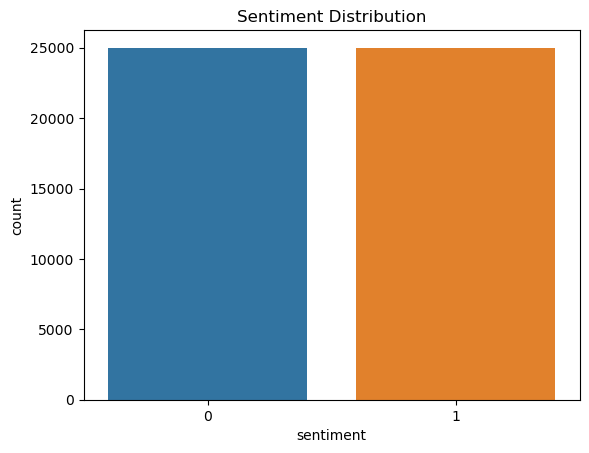

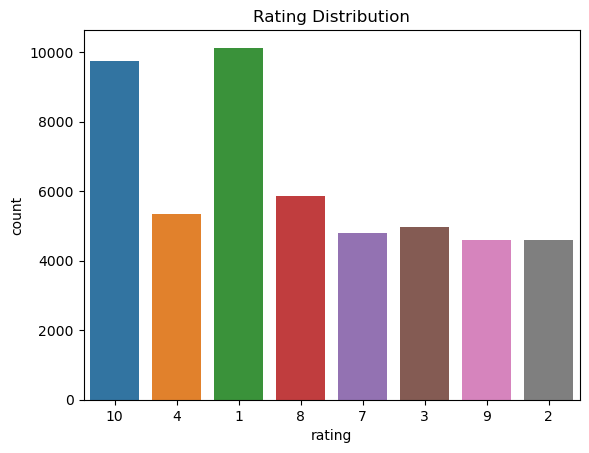

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df['sentiment'])
plt.title('Sentiment Distribution')
plt.show()

sns.countplot(x=df['rating'])
plt.title('Rating Distribution')
plt.show()

In [19]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ankitbatchali/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [20]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z]', ' ', text)
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)

df['review'] = df['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankitbatchali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ankitbatchali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000), {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['saga']}),
    ('k-Nearest Neighbors', KNeighborsClassifier(), {'n_neighbors': [5, 7, 10]}),
    ('Support Vector Machines', SVC(), {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 'scale', 'auto'], 'kernel': ['linear', 'rbf']}),
    ('Decision Trees', DecisionTreeClassifier(), {'max_depth': [None, 3, 5], 'min_samples_leaf': [2, 3, 4]}),
    ('Random Forest', RandomForestClassifier(), {'n_estimators': [100, 300, 500, 1000], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    ('Gradient Boosting', GradientBoostingClassifier(), {'n_estimators': [100, 300, 500], 'learning_rate': [0.001, 0.01, 0.1], 'max_depth': [3, 5, 8]}),
    ('XGBoost', XGBClassifier(eval_metric='logloss'), {'n_estimators': [100, 300, 1000], 'learning_rate': [0.001, 0.01, 0.1], 'max_depth': [3, 6, 10], 'subsample': [0.5, 0.8, 1.0], 'colsample_bytree': [0.5, 0.8, 1.0]}),
    ('LightGBM', LGBMClassifier(), {'n_estimators': [100, 300, 1000], 'learning_rate': [0.001, 0.01, 0.1], 'max_depth': [-1, 5, 8, 12], 'colsample_bytree': [0.5, 0.8, 1.0]}),
    ('CatBoost', CatBoostClassifier(verbose=0), {'iterations': [100, 300, 1000], 'learning_rate': [0.001, 0.01, 0.1], 'depth': [4, 7, 10]}),
    ('AdaBoost', AdaBoostClassifier(), {'n_estimators': [50, 100], 'learning_rate': [0.01]}),
    ('Bagging', BaggingClassifier(), {'n_estimators': [5, 10]}),
    ('Extra Trees', ExtraTreesClassifier(), {'n_estimators': [50, 100], 'max_depth': [None, 3, 5]}),
    ('SGD', SGDClassifier(), {'alpha': [0.0001, 0.001, 0.01, 0.1], 'penalty': ['l1', 'l2', 'elasticnet'], 'l1_ratio': [0.15, 0.5, 0.85]}),
    ('Passive Aggressive', PassiveAggressiveClassifier(), {'C': [0.1, 1, 10], 'loss': ['hinge']}),
    ('Ridge', RidgeClassifier(), {'alpha': [0.1, 1.0]}),
    ('Nearest Centroid', NearestCentroid(), {}),
    ('GaussianNB', GaussianNB(), {}),
    ('BernoulliNB', BernoulliNB(), {'alpha': [0.1, 1.0]}),
    ('Linear Discriminant Analysis', LinearDiscriminantAnalysis(), {'solver': ['svd', 'lsqr']}),
    ('Quadratic Discriminant Analysis', QuadraticDiscriminantAnalysis(), {}),
]


In [ ]:
results = pd.DataFrame(columns=[
    'Model', 'Best Parameters', 'Accuracy', 'Precision', 'Recall', 
    'F1-Score', 'Confusion Matrix', 'ROC AUC', 'Loss', 'PR AUC', 'Average Precision'
])

# Set up the PDF to save plots
from matplotlib.backends.backend_pdf import PdfPages
pdf_pages = PdfPages('plots.pdf')

for name, model, params in models:
    print(f"Training {name}...")
    
    gs = GridSearchCV(model, params, cv=5, scoring='roc_auc')  
    gs.fit(X_train_vec, y_train)
    print(f"Best parameters for {name}: {gs.best_params_}")
    
    model = gs.best_estimator_
    y_pred = model.predict(X_test_vec)
    
    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(X_test_vec)[:,1]
        roc_auc = roc_auc_score(y_test, probabilities)
        loss = log_loss(y_test, probabilities)
        
        # Precision-Recall Curve
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, probabilities)
        pr_auc = auc(recall_curve, precision_curve)
        avg_precision = average_precision_score(y_test, probabilities)
    else:
        roc_auc = 'N/A'
        loss = 'N/A'
        pr_auc = 'N/A'
    
    # Store metrics in the results dataframe
    results = pd.concat([results, pd.DataFrame([{
        'Model': name, 
        'Best Parameters': str(gs.best_params_), 
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Confusion Matrix': json.dumps(conf_matrix.tolist()),
        'ROC AUC': roc_auc,
        'Loss': loss,
        'PR AUC': pr_auc,
        'Average Precision': avg_precision
    }])], ignore_index=True)
    
    # Plot ROC curve
    if hasattr(model, 'predict_proba'):
        fpr, tpr, _ = roc_curve(y_test, probabilities)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.title(f'ROC Curve for {name}')
        pdf_pages.savefig()
    
    # Plot Precision-Recall curve
    if hasattr(model, 'predict_proba'):
        plt.figure()
        plt.plot(recall_curve, precision_curve)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {name}')
        pdf_pages.savefig()
    
    #confusion matrix heatmap
    plt.figure()
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {name}')
    pdf_pages.savefig()
    
    #Plot predicted probabilities
    if hasattr(model, 'predict_proba'):
        plt.figure()
        plt.hist(probabilities, bins=20, alpha=0.75, label='Predicted Probabilities')
        plt.title(f'Predicted Probabilities for {name}')
        plt.xlabel('Probability')
        plt.ylabel('Frequency')
        pdf_pages.savefig()

    # ... [Add more plots as needed]

pdf_pages.close()
results.to_csv('model_results.csv', index=False)


Training Logistic Regression...


/Users/ankitbatchali/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ankitbatchali/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ankitbatchali/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ankitbatchali/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Training k-Nearest Neighbors...
Best parameters for k-Nearest Neighbors: {'n_neighbors': 10}
Training Support Vector Machines...
